首先来找点数据:
# 美国货物进口总额与海关关税收入数据获取指南

## 一、Total U.S. Imports of Goods (美国货物进口总额) 数据获取

### 方法1：通过FRED(Federal Reserve Economic Data)下载

1. **访问FRED网站**：https://fred.stlouisfed.org/
2. 在搜索框中输入：`Imports of Goods for United States`
3. 在搜索结果中找到名为"Imports of Goods for United States (IMPTOTUS)"的系列 
   - **频率**：月度(Monthly)
   - **单位**：百万美元(Millions of Dollars)，未季节调整(Not Seasonally Adjusted)
   - **来源**：U.S. Census Bureau
4. 点击该系列进入详情页，页面右上角有"Download"按钮，可选择以下格式下载 ：
   - **Excel (.xlsx)**：适合使用Microsoft Excel分析
   - **CSV (.csv)**：适合使用其他数据分析软件

### 方法2：直接访问FRED数据页面下载

直接访问以下URL，可查看并下载数据 ：
https://fred.stlouisfed.org/series/IMPTOTUS

**数据特点**：
- 时间范围：2008年1月至今 
- 最新数据(2025年7月)：292,244.90百万美元(约2,922亿美元) 

## 二、Customs Duties (海关关税收入) 数据获取

### 方法1：通过美国财政部(Department of Treasury)的Monthly Treasury Statement获取

1. 访问财政部Monthly Treasury Statement页面：https://fiscal.treasury.gov/reports-statements/mts/current.html 
2. 下载最新月度报告(PDF或Excel格式)
3. 在报告中查找"Customs Duties"(海关关税)或"Net Customs Receipts"(净海关收入)项目 

### 方法2：通过USITC的DataWeb平台获取

1. 访问USITC的DataWeb网站：https://dataweb.usitc.gov/ 
2. 点击"New Data Request"创建新的数据请求 
3. 在"Trade Flow"部分选择"Imports: For Consumption"
4. 在"Data to Report"部分勾选"Collected Duties"(已收关税)和"Value of Imports"(进口价值)
5. 选择时间范围(月度)，点击"Continue"
6. 在下一页选择所需的分类系统(如HTS编码)，点击"Continue"
7. 生成报告后，点击"Download"下载Excel或CSV格式数据 

### 方法3：直接访问USITC关税数据统计表

USITC提供历史关税数据统计表，包含1891-2021年的年度和月度数据：
https://www.usitc.gov/documents/dataweb/ave_table_1891_2021.pdf 

## 三、数据使用建议

1. **数据匹配**：将货物进口总额与关税收入数据结合，可以计算平均关税率(关税收入÷进口总额) 

2. **最新数据参考**：
   - 2025年8月美国关税收入达314亿美元，创历史新高 
   - 2025财年前8个月(截至8月)累计关税收入超2,149亿美元 

## 四、注意事项

- **数据来源差异**：关税收入数据在财政部报表中称为"Customs Duties"，在USITC中称为"Collected Duties"，两者数值基本一致，但财政部数据已扣除退税和退款 

- **数据完整性**：
  - FRED的货物进口数据始于2008年
  - USITC的关税数据可追溯至19世纪末 

- **更新频率**：
  - 月度数据通常在次月中旬发布
  - 建议定期检查官方网站获取最新更新

**总结**：通过上述方法，您可以方便地获取美国货物进口总额和海关关税收入的月度数据。FRED提供了简洁的数据下载界面，而USITC的DataWeb则提供了更灵活的数据筛选和定制功能。若需长期跟踪分析，建议同时使用这两个数据源以相互验证。

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

df_imports = pd.read_csv(r'..\..\data\raw\Q4\IMPTOTUS.csv')
df_imports.head()

# plt.plot(df_imports['observation_date'],df_imports['IMPTOTUS'])
# plt.xlabel('Month')
# plt.ylabel('Imports (in billions of US dollars)')
# plt.title('Imports of United States')
# plt.show()

# df_imports['IMPTOTUS_DIFF'] = df_imports['IMPTOTUS'].astype(float).diff()
# plt.plot(df_imports['observation_date'],df_imports['IMPTOTUS_DIFF'])
# plt.xlabel('Month')
# plt.title('Imports of United States')
# plt.show()
# print(df_imports['IMPTOTUS_DIFF'].mean(), df_imports['IMPTOTUS_DIFF'].std())

# df_imports['IMPTOTUS_std']= df_imports['IMPTOTUS_DIFF'].astype(float).rolling(window=5,min_periods=1).std()
# plt.plot(df_imports['observation_date'],df_imports['IMPTOTUS_std'])
# plt.xlabel('Month')
# plt.title('Imports of United States')
# plt.show()

,observation_date,IMPTOTUS
0,2008-01-01,168350.2
1,2008-02-01,165069.7
2,2008-03-01,171194.0
3,2008-04-01,182115.1
4,2008-05-01,182956.3


(开始尝试一下最简单的时间序列分析)这个直接使用AI编程就行了

尝试探索一下第一次关税战的对进口额的影响:
1. 绘制一下2017-2020年的进口额变化趋势, 简单计算一些统计量
2. 尝试获得关税幅度的数据


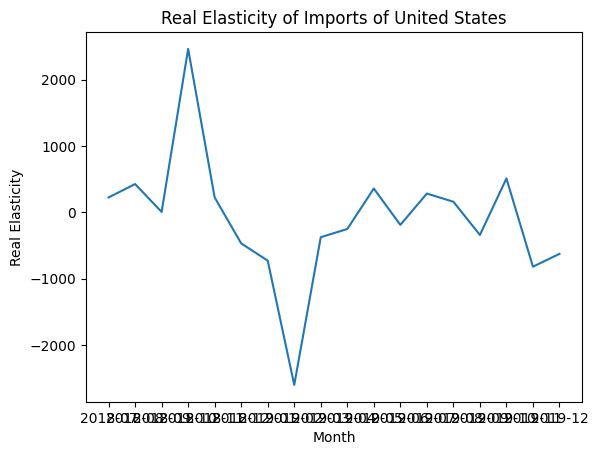

observation_date
2018-07-01     224.062477
2018-08-01     425.772106
2018-09-01       6.481169
2018-10-01    2460.504973
2018-11-01     224.037157
2018-12-01    -467.492549
2019-01-01    -727.192691
2019-02-01   -2598.513012
2019-03-01    -374.161629
2019-04-01    -251.051983
2019-05-01     358.197943
2019-06-01    -188.843326
2019-07-01     282.339364
2019-08-01     159.726149
2019-09-01    -340.248542
2019-10-01     509.896806
2019-11-01    -818.540517
2019-12-01    -625.020529
Name: IMPTOTUS_DIFF_from_head, dtype: float64
基于历史数据训练的参数: 短期弹性=943.12, 长期弹性=-342.02, 调整速度=0.25


C:\Users\danchen\AppData\Local\Temp\ipykernel_42760\441411130.py:91: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  popt, pcov = curve_fit(decay_func, months_index, real_elasticities, p0=[real_elasticities[0], real_elasticities[-1], 0.1])


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


df_imports = pd.read_csv(r'..\..\data\raw\Q4\IMPTOTUS.csv')
# df_imports['observation_date'] = pd.to_datetime(df_imports['observation_date'])
df_imports.set_index('observation_date', inplace=True)
df_imports.head()

# df_imports_2017_2020=df_imports.loc["2017-01-01":"2020-12-01"].copy()
# df_imports_2017_2020.head()
# df_imports_2017_2020.to_csv(r'..\..\data\processed\Q4_IMPTOTUS_2017_2020.csv', index=True)


# plt.plot(df_imports_2017_2020.index,df_imports_2017_2020['IMPTOTUS'])
# plt.xlabel('Month')
# plt.ylabel('Imports(in billions of US dollars)')
# plt.title('Imports of United States')
# plt.show()
# print(df_imports['IMPTOTUS'].mean(), df_imports['IMPTOTUS'].std())


# df_imports_2017_2020['IMPTOTUS_DIFF'] = df_imports_2017_2020['IMPTOTUS'].diff()
# plt.plot(df_imports_2017_2020.index,df_imports_2017_2020['IMPTOTUS_DIFF'])
# plt.xlabel('Month')
# plt.ylabel('Imports diff (in billions of US dollars)')
# plt.title('Imports of United States')
# plt.show()
# print(df_imports_2017_2020['IMPTOTUS_DIFF'].mean(), df_imports_2017_2020['IMPTOTUS_DIFF'].std())

tariff_rates = np.array([
    25,   # 2018-07：340亿美元商品加征25%
    25,   # 2018-08：新增160亿美元商品加征25%
    10,   # 2018-09：2000亿美元商品加征10%
    10,   # 2018-10
    10,   # 2018-11
    10,   # 2018-12
    10,   # 2019-01
    10,   # 2019-02
    10,   # 2019-03
    10,   # 2019-04
    25,   # 2019-05：2000亿美元商品关税提高至25%
    25,   # 2019-06
    25,   # 2019-07
    25,   # 2019-08
    15,   # 2019-09：新增1120亿美元商品加征15%
    15,   # 2019-10
    15,   # 2019-11
    15    # 2019-12：原计划新增1600亿美元商品加征15%
])

# 对应的月份标签
months = np.array([
    '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
    '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
    '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12'
])
# months_index = np.array([
#     1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18
# ])

df_imports_trade_war=df_imports.loc["2018-06-01":"2019-12-01"].copy()
df_imports_trade_war.head()
df_imports_trade_war.tail()
# df_imports_trade_war.to_csv(r'..\..\data\processed\Q4_IMPTOTUS_2017_2020.csv', index=True)

df_imports_trade_war['IMPTOTUS_DIFF'] = df_imports_trade_war['IMPTOTUS'].diff()
df_imports_trade_war.head()
df_imports_trade_war.tail()

df_imports_trade_war['IMPTOTUS_DIFF_from_head'] = df_imports_trade_war['IMPTOTUS_DIFF'].cumsum()
df_imports_trade_war.head()
df_imports_trade_war.tail()
df_imports_trade_war.drop(index='2018-06-01', inplace=True)

real_elasticities=df_imports_trade_war['IMPTOTUS_DIFF_from_head']/tariff_rates
plt.plot(months,real_elasticities)
plt.xlabel('Month')
plt.ylabel('Real Elasticity')
plt.title('Real Elasticity of Imports of United States')
plt.show()
print(real_elasticities)

# 定义衰减方程
def decay_func(t, e_short, e_long, speed):
    return e_long - (e_long - e_short) * np.exp(-speed * t)

# curve_fit：根据观测数据（months, real_elasticities），找到使模型最贴近数据的参数
popt, pcov = curve_fit(decay_func, months_index, real_elasticities, p0=[real_elasticities[0], real_elasticities[-1], 0.1])

# 获取“科学”的参数
fitted_e_short, fitted_e_long, fitted_speed = popt

print(f"基于历史数据训练的参数: 短期弹性={fitted_e_short:.2f}, 长期弹性={fitted_e_long:.2f}, 调整速度={fitted_speed:.2f}")

# df_imports['IMPTOTUS_DIFF_STD'] = df_imports.rolling(window=12,min_periods=1).std()
# plt.plot(df_imports['observation_date'],df_imports['IMPTOTUS_DIFF_STD'])
# plt.xlabel('Month')
# plt.ylabel('Imports diff STD (in billions of US dollars)')
# plt.title('Imports of United States')
# plt.show()

尝试一下修改逻辑的代码

C:\Users\danchen\AppData\Local\Temp\ipykernel_42760\3154378687.py:63: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
e:\RESEARCH\APMCM\Math_Modeling_APMCM\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


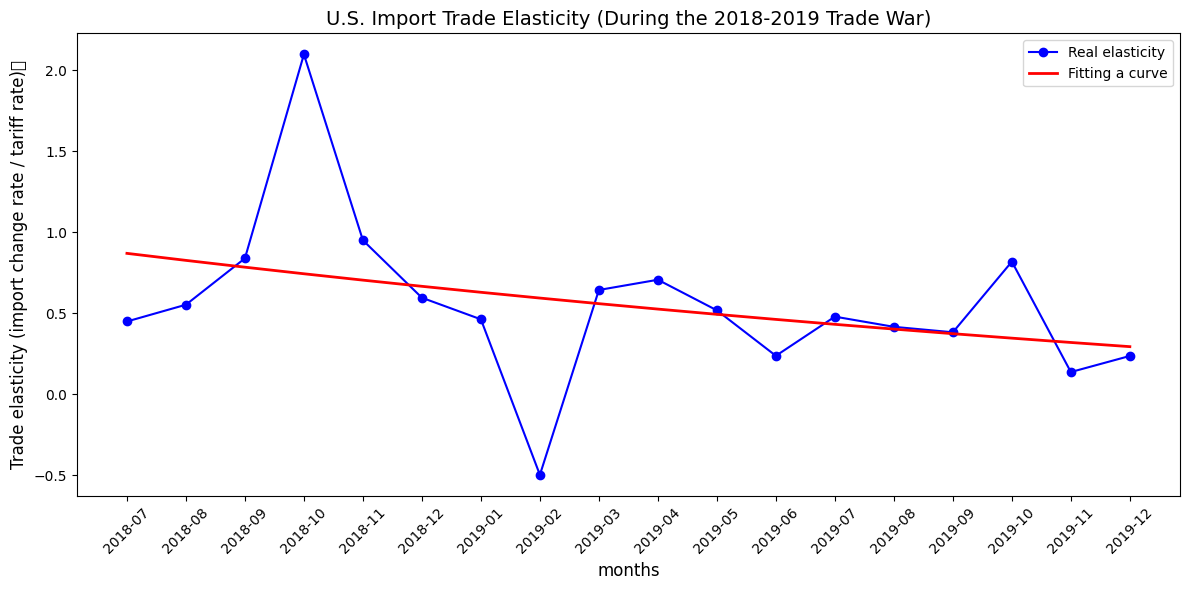

基于历史数据训练的参数: 短期弹性=0.91, 长期弹性=-0.49, 调整速度=0.03
真实弹性序列：
                       月份  关税幅度(%)   真实弹性
observation_date                         
2018-07-01        2018-07       25  0.449
2018-08-01        2018-08       25  0.553
2018-09-01        2018-09       10  0.839
2018-10-01        2018-10       10  2.097
2018-11-01        2018-11       10  0.950
2018-12-01        2018-12       10  0.596
2019-01-01        2019-01       10  0.462
2019-02-01        2019-02       10 -0.497
2019-03-01        2019-03       10  0.643
2019-04-01        2019-04       10  0.707
2019-05-01        2019-05       25  0.518
2019-06-01        2019-06       25  0.237
2019-07-01        2019-07       25  0.479
2019-08-01        2019-08       25  0.416
2019-09-01        2019-09       15  0.382
2019-10-01        2019-10       15  0.818
2019-11-01        2019-11       15  0.137
2019-12-01        2019-12       15  0.236


In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# -------------------------- 1. 数据读取与预处理（修正日期索引）--------------------------
df_imports = pd.read_csv(r'..\..\data\raw\Q4\IMPTOTUS.csv')
# 关键：将日期转为datetime类型（必须执行，否则日期切片失效）
df_imports['observation_date'] = pd.to_datetime(df_imports['observation_date'])
df_imports.set_index('observation_date', inplace=True)

# 筛选贸易战期间数据（2018-07 到 2019-12，与关税月份完全对齐）
df_imports_trade_war = df_imports.loc["2018-07-01":"2019-12-01"].copy()
# 检查是否有18个月份（与tariff_rates数量一致），删除缺失值
df_imports_trade_war = df_imports_trade_war.dropna()
assert len(df_imports_trade_war) == 18, f"数据量不对，应为18个月，实际为{len(df_imports_trade_war)}个月"

# -------------------------- 2. 关税数据定义（保持不变，确保与月份对齐）--------------------------
tariff_rates = np.array([
    25, 25, 10, 10, 10, 10, 10, 10, 10, 10, 25, 25, 25, 25, 15, 15, 15, 15
])
months = np.array([
    '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
    '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
    '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12'
])
# 定义“关税生效后的第n个月”（拟合模型需要数值型自变量）
months_index = np.arange(1, len(months)+1)  # [1,2,...,18]

# -------------------------- 3. 修正弹性计算逻辑（关键！）--------------------------
# 步骤1：计算“贸易量变化率”（相对于贸易战前的基准值，这里用2017年平均进口额作为基准）
baseline_2017 = df_imports.loc["2017-01-01":"2017-12-01", "IMPTOTUS"].mean()  # 2017年平均进口额（基准）
df_imports_trade_war['import_growth_rate'] = (df_imports_trade_war['IMPTOTUS'] - baseline_2017) / baseline_2017  # 进口变化率（%）

# 步骤2：计算真实弹性 = 进口变化率 / 关税幅度（关税幅度需转为小数，如25%→0.25）
real_elasticities = df_imports_trade_war['import_growth_rate'] / (tariff_rates / 100)
# 弹性含义：关税每加征1%，进口量变化多少%（负值=进口下降）

# -------------------------- 4. 模型拟合与可视化（修正变量未定义问题）--------------------------
# 定义衰减模型（保持不变）
def decay_func(t, e_short, e_long, speed):
    return e_long - (e_long - e_short) * np.exp(-speed * t)

# 拟合模型（用数值型的months_index作为自变量，设置合理初始值）
popt, pcov = curve_fit(
    decay_func, 
    xdata=months_index, 
    ydata=real_elasticities,
    p0=[real_elasticities.iloc[0], real_elasticities.iloc[-1], 0.1],  # 初始值：短期弹性=第一个观测值，长期弹性=最后一个观测值
    maxfev=5000  # 增加迭代次数，避免拟合失败
)
fitted_e_short, fitted_e_long, fitted_speed = popt

# 绘制真实弹性与拟合曲线
plt.figure(figsize=(12, 6))
plt.plot(months_index, real_elasticities, 'o-', label='Real elasticity', color='blue')
plt.plot(months_index, decay_func(months_index, *popt), '-', label='Fitting a curve', color='red', linewidth=2)
plt.xticks(months_index, months, rotation=45)  # 旋转x轴标签，避免拥挤
plt.xlabel('months', fontsize=12)
plt.ylabel('Trade elasticity (import change rate / tariff rate)）', fontsize=12)
plt.title('U.S. Import Trade Elasticity (During the 2018-2019 Trade War)', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------- 5. 输出结果与保存数据--------------------------
print(f"基于历史数据训练的参数: 短期弹性={fitted_e_short:.2f}, 长期弹性={fitted_e_long:.2f}, 调整速度={fitted_speed:.2f}")
print("真实弹性序列：")
print(pd.DataFrame({'月份': months, '关税幅度(%)': tariff_rates, '真实弹性': real_elasticities.round(3)}))

# 保存处理后的数据（避免覆盖，用不同文件名）
df_imports_trade_war['True elasticity'] = real_elasticities
df_imports_trade_war.to_csv(r'..\..\data\processed\Q4_IMPTOTUS_trade_war_elasticity.csv', index=True)